<a href="https://colab.research.google.com/github/AbdennourKerPro/Machine-Learning/blob/main/TP06_DDPMs_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP06 : Generating images with DDPMs

Something something Diffusion models

## Setup and imports

In [ ]:
!pip3 install --upgrade pip
!pip3 install einops

In [ ]:
# Import of libraries
import os
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from IPython.display import clear_output

import torchvision.transforms as transforms
from torchvision.datasets.mnist import FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [ ]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))


Using device: cuda	Tesla T4


# 1. Understanding the DDPM :

The central idea behind Diffusion models is to take each training image and to corrupt it using a multi-step noise process to transform it into a sample from a Gaussian distribution. A deep neural network is then trained to invert this process, and once trained the network can then generate new images starting with samples from a Gaussian as an input.

A diffusion model consists of a **Forward (Diffusion) Process** and a **Reverse (Denoising/Generative) Process**. The **Forward Process** takes a data sample $\mathbf{x}_0$ and gradually maps it through a series of intermediate noisy states $\mathbf{x}_{1} \dots \mathbf{x}_{T}$. The **Reverse Process** reverses this; it starts with $\mathbf{x}_{T}$ (pure noise) and maps back through $\mathbf{x}_{T-1} \dots \mathbf{x}_1$ until it finally recreates a datapoint $\mathbf{x}_0$. In both processes, the mappings are stochastic rather than deterministic.

### A. Forward Diffusion Process

The Forward Process is fixed (prespecified); it gradually blends the input with samples of white noise. With enough steps, the **data is completely indistinguishable from pure Gaussian noise $\mathbf{x}_T$**.

* **Process:** An image is slowly and systematically corrupted by adding tiny amounts of Gaussian noise over many steps.

#### 1. Single Step Transition

The corruption from step $t-1$ to $t$ is defined by a simple Gaussian distribution, where $\beta_t$ controls the noise variance.

$$q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t\mathbf{I})$$

* **Key Parameter:** We define $\alpha_t = 1 - \beta_t$. The set of $\beta_t$ values is the **Noise Schedule** that we must pre-define (e.g., linear or cosine).

#### 2. Key Trick: Sampling $\mathbf{x}_t$ Directly

For training efficiency, we use the closed-form expression to sample the noisy image $\mathbf{x}_t$ directly from the original image $\mathbf{x}_0$ at any time $t$. This avoids running the entire sequential process during every training iteration.

This closed-form equation is the **core of the `q_sample` function we will implement:**

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\epsilon$$

* **Where:**
    * $\bar{\alpha}_t = \prod _{i=1}^{t}\alpha_i $ (the cumulative product of alphas).
    * $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ (pure Gaussian noise sampled for each training step).

* **Implementation Note:** We pre-calculate and store all the $\sqrt{\bar{\alpha}_t}$ and $\sqrt{1-\bar{\alpha}_t}$ terms derived from our noise schedule ($\beta_t$).

---

### B. Reverse Denoising Process

The Reverse Process is the learned part; the model trains a neural network (typically a U-Net) to predict the noise added at each step. This allows the model to accurately estimate the reverse transition, **effectively learning how to systematically denoise an image to generate a new sample**.

* **The Goal:** To learn the transition $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t)$, which is approximated as a Gaussian distribution.

#### 1. The Generative Step

The reverse step is also Gaussian, but its mean $\boldsymbol{\mu}_\theta$ and variance $\boldsymbol{\Sigma}_\theta$ are learned:

$$p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))$$

#### 2. Using the Noise Predictor ($\epsilon_\theta$)

In the DDPM paper, the variance $\boldsymbol{\Sigma}_\theta$ is fixed, and the neural network $\epsilon_\theta$ is trained to predict the noise $\epsilon$ which allows us to *compute* the required mean $\boldsymbol{\mu}_\theta$.

The predicted mean $\boldsymbol{\mu}_\theta$ used in the generative (sampling) step is:

$$\boldsymbol{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$

* **Implementation Note:** This equation is the **core of the `p_sample` function** we will write for image generation. We feed the noisy image $\mathbf{x}_t$ and the time $t$ to our U-Net $\boldsymbol{\epsilon}_\theta$, and use its prediction to calculate $\boldsymbol{\mu}_\theta$.

---

### C. The Simplified Objective Function (Predicting the Noise)

The entire training task simplifies to training a neural network $\epsilon_\theta$ to predict the noise $\epsilon$ added at step $t$.

The training loss is a Mean Squared Error (MSE) between the true noise $\epsilon$ and the predicted noise $\epsilon_\theta$

# 2. Loading data
We will use the FashionMNIST dataset and try to generate some new samples out of random gaussian noise. We normalize the input images to the range `[-1,1]`.

In [ ]:
BATCH_SIZE = 256

In [ ]:
CLASS_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

print(f"Total number of training samples: {len(dataset)}")
print(f"Number of batches: {len(loader)}")


Total number of training samples: 60000
Number of batches: 235


## 2.1. Helper functions

Following are two utility functions: `show_images` allows to display images in a square-like pattern with a custom title, while `show_fist_batch` simply shows the images in the first batch of a DataLoader object.

In [ ]:
## 3. Visualization Helper Function and Sample Check (Revised)

def show_images(images, title=""):
    """
    Denormalizes images and displays them in a grid.
    Handles the common DDPM normalization range of [-1, 1].
    """
    if type(images) is torch.Tensor:
        images = images.detach().cpu()

    # Undo normalization
    images = (images + 1) * 0.5

    # Determine grid size (e.g., 4x4 for up to 16 images
    num_images = min(len(images), 36) # Limit to 36 for clean display
    rows = int(np.sqrt(num_images))
    cols = (num_images + rows - 1) // rows # Ceiling division for columns

    fig = plt.figure(figsize=(8, 8))

    for idx in range(num_images):
        ax = fig.add_subplot(rows, cols, idx + 1)

        img = images[idx]

        # Permute (C, H, W) to (H, W, C) and squeeze the channel for grayscale
        if img.dim() == 3 and img.shape[0] == 1:
            # Grayscale (1, H, W) -> (H, W)
            img = img.squeeze(0)

        plt.imshow(img.numpy().clip(0, 1), cmap="gray")
        ax.axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

def show_first_batch(loader):
    """Iterates through the loader and displays the first batch."""
    for batch in loader:
        # batch[0] is the image tensor
        show_images(batch[0], "Sample Images in the First Batch")
        break


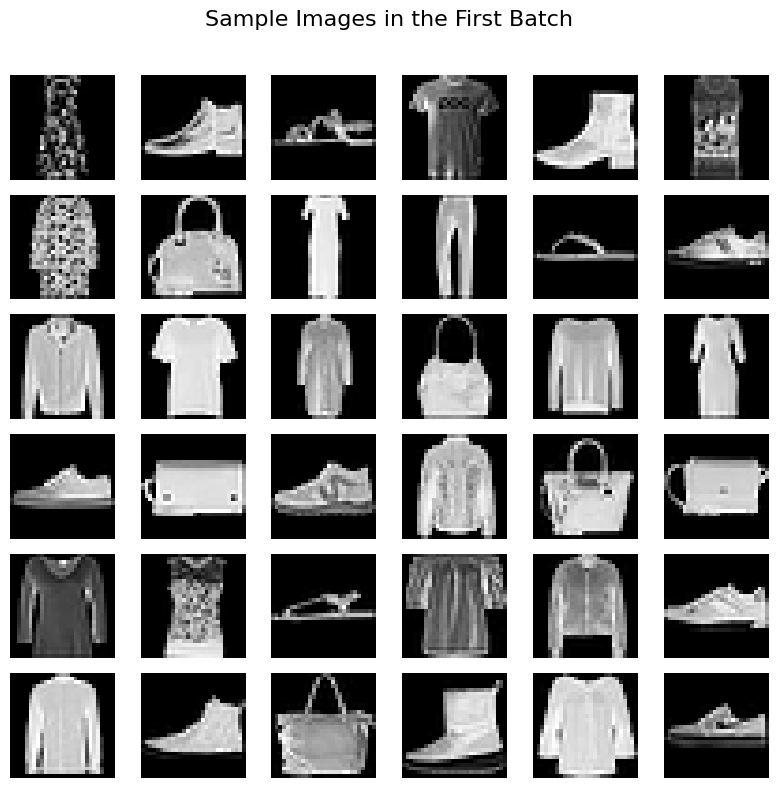

In [ ]:
show_first_batch(loader)

# 3. Basic DDPM implementation

## 3.1. Noise Predictor Network (U-Net)

Our architecture choice for this diffusion modelis the **U-Net**. It is a type of CNN that was initially developed for biomedical image segmentation tasks. Its architecture is characterized by a symmetric shape which gives it the "U" name.

Its fundamentals are:

* **Contracting Path/Encoder (Downsampling):** This is the left side of the U, where the input image goes through several layers of convolutions and pooling operations. This path is responsible for capturing the context of the input image. The downsampling helps the network understand what features are present in the image, albeit at a reduced resolution.
* **Expansive Path/Decoder (Upsampling):** This is the right side of the U, which consists of transposed convolutions and concatenation followed by regular convolutions. The purpose of this path is to enable precise localization using the contextual information gained from the contracting path, allowing for high-resolution output.
* **Skip Connections:** One distinctive feature of the U-Net is the use of skip connections. These provide a pathway to carry information directly from the encoder layers to the corresponding decoder layers. This helps to recover the spatial context lost during the downsampling operations, which is critical for tasks like image segmentation and **denoising** where precise boundaries and localization are necessary.

The Diffusion Model must perform the reverse (denoising) operation at **every single timestep $t$ from $T$ down to $1$**. Training a separate model for each of the $T$ steps would be impractical and highly inefficient.

Therefore, **we use a single,  neural network to handle all denoising steps.** Since we use a single model instead of a model for each denoising step, it must be **conditioned on the time step $t$**. The time step $t$ must be injected into the network at every layer so the model knows how much noise to predict.

### 3.1.1. Sinusoidal Time Embedding


Transforms discrete timestep $t$ into a continuous embedding using sinusoidal functions:

$$\text{emb}(t) = \left[\sin(\omega_1 t), \cos(\omega_1 t), \ldots, \sin(\omega_{d/2} t), \cos(\omega_{d/2} t)\right]$$

where $\omega_k = \exp\left(-\frac{k \ln(10000)}{d/2 - 1}\right)$ for $k = 0, 1, \ldots, d/2-1$.

This encoding provides the model with positional information about the noise level.


In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


### 3.1.2. U-Net building blocks


In [ ]:
class DoubleBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, normalize=True):
        super(DoubleBlock, self).__init__()

        # Layer Normalization :
        self.ln = nn.LayerNorm(shape)
        self.normalize = normalize

        # Two consecutive convolutional layers :
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)

        # Activation function (SILU is a common choice in modern diffusion models)
        self.activation = nn.SiLU()

    def forward(self, x):

        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)

        return out


### 3.1.3. Full U-Net architecture


In [ ]:
class BasicUNet(nn.Module):

    def __init__(self, timesteps=1000, time_emb_dim=100):

        super(BasicUNet, self).__init__()

        # Sinusoidal embedding (Assumes TimeEmbedding is defined in 3.1.1)
        self.time_emb = TimeEmbedding(time_emb_dim)

        # Helper to create Time Projection Layers
        self.te1 = self._make_te(time_emb_dim, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.te_out = self._make_te(time_emb_dim, 20)

        # --- Downsampling Path (Encoder) ---
        self.b1 = nn.Sequential(
            DoubleBlock((1, 28, 28), 1, 10),
            DoubleBlock((10, 28, 28), 10, 10),
            DoubleBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1) # 28 -> 14

        self.b2 = nn.Sequential(
            DoubleBlock((10, 14, 14), 10, 20),
            DoubleBlock((20, 14, 14), 20, 20),
            DoubleBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1) # 14 -> 7

        self.b3 = nn.Sequential(
            DoubleBlock((20, 7, 7), 20, 40),
            DoubleBlock((40, 7, 7), 40, 40),
            DoubleBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential( # 7 -> 3
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # --- Bottleneck ---
        self.b_mid = nn.Sequential(
            DoubleBlock((40, 3, 3), 40, 20),
            DoubleBlock((20, 3, 3), 20, 20),
            DoubleBlock((20, 3, 3), 20, 40)
        )

        # --- Upsampling Path (Decoder) ---
        self.up1 = nn.Sequential( # 3 -> 7 (Reverse of down3)
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.b4 = nn.Sequential( # Input 40 (b3 skip) + 40 (up1 output) = 80
            DoubleBlock((80, 7, 7), 80, 40),
            DoubleBlock((40, 7, 7), 40, 20),
            DoubleBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1) # 7 -> 14
        self.b5 = nn.Sequential( # Input 20 (b2 skip) + 20 (up2 output) = 40
            DoubleBlock((40, 14, 14), 40, 20),
            DoubleBlock((20, 14, 14), 20, 10),
            DoubleBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1) # 14 -> 28
        self.b_out = nn.Sequential( # Input 10 (b1 skip) + 10 (up3 output) = 20
            DoubleBlock((20, 28, 28), 20, 10),
            DoubleBlock((10, 28, 28), 10, 10),
            DoubleBlock((10, 28, 28), 10, 10, normalize=False)
        )

        # Final output convolution (10 channels -> 1 output channel for noise prediction)
        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)


    def forward(self, x, t):
        # 1. Compute time embedding vector
        t_emb = self.time_emb(t)
        n = len(x)

        # --- Encoder Path with Time Injection ---
        # Time projection must match the channel dimension (e.g., 10 for b1)
        out1 = self.b1(x + self.te1(t_emb).reshape(n, -1, 1, 1))
        out2 = self.b2(self.down1(out1) + self.te2(t_emb).reshape(n, -1, 1, 1))
        out3 = self.b3(self.down2(out2) + self.te3(t_emb).reshape(n, -1, 1, 1))

        # --- Bottleneck ---
        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t_emb).reshape(n, -1, 1, 1))

        # --- Decoder Path with Skip Connections and Time Injection ---
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
        out4 = self.b4(out4 + self.te4(t_emb).reshape(n, -1, 1, 1))

        out5 = torch.cat((out2, self.up2(out4)), dim=1)
        out5 = self.b5(out5 + self.te5(t_emb).reshape(n, -1, 1, 1))

        out = torch.cat((out1, self.up3(out5)), dim=1)
        out = self.b_out(out + self.te_out(t_emb).reshape(n, -1, 1, 1))

        # Final output
        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        """Creates the sequential layers for projecting the time embedding vector."""
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )


In [ ]:
TIME_EMB_DIM = 100

basic_unet = BasicUNet(time_emb_dim=TIME_EMB_DIM).to(device)

# --- Parameter Count ---
total_params = sum(p.numel() for p in basic_unet.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params:,}")


Total number of trainable parameters: 506,852


## 3.2. Basic DDPM class implementation

In [ ]:
class BasicDDPM:

    def __init__(self, model, timesteps=1000, device='cuda', min_beta=10 ** -4, max_beta=0.02):

        self.model = model
        self.timesteps = timesteps
        self.device = device

        # Linear beta schedule :
        self.betas = torch.linspace(min_beta, max_beta, timesteps).to(device)
        self.alphas = 1 - self.betas

        # calculate alpha_bar :
        # alpha_bar is defined as : alpha_bar_t = product_{i=1}^{t} (1 - beta_i)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        # alpha_bar prev is : alpha_bar_{t-1}
        self.alpha_bars_prev = torch.cat([torch.tensor([1.0], device=device), self.alpha_bars[:-1]])

        # Pre calculated  terms for q_sample  (Forward Process)
        # Used for the forward equation: x_t = sqrt(alpha_bar_t)*x_0 + sqrt(1 - alpha_bar_t)*epsilon
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

        # Pre calculated terms for sample (Reverse Process)
        # sqrt(1/alpha_t): Used in the mean calculation mu_theta(x_t, t)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Posterior Variance (tilde_beta_t): The fixed variance for the reverse step
        # tilde_beta_t = beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
        self.posterior_variance = self.betas * (1. - self.alpha_bars_prev) / (1. - self.alpha_bars)

    def q_sample(self, x_0, t, noise=None):

        """
        The Forward Process: Samples x_t directly from x_0.
        Uses the pre-calculated sqrt_alpha_bars and sqrt_one_minus_alpha_bars.
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_ab = self.sqrt_alpha_bars[t].view(-1, 1, 1, 1)
        sqrt_omab = self.sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)
        return sqrt_ab * x_0 + sqrt_omab * noise

    def compute_loss(self, x_0, t):
        """
        Calculates the loss for the training step: ||epsilon - epsilon_theta||^2.

        Args:
            x_0 (Tensor): The batch of clean images (x_0).
            t (Tensor): The batch of random timesteps (t).
        """
        b = x_0.size(0)

        # 1. Sample the true noise (epsilon)
        noise = torch.randn_like(x_0)

        # 2. Add noise using the forward process
        x_t = self.q_sample(x_0, t, noise=noise)

        # 3. U-Net predicts the noise (epsilon_theta)
        noise_pred = self.model(x_t, t)

        # 4. Calculate the Loss (Mean Squared Error between true noise and predicted noise)
        return F.mse_loss(noise, noise_pred)

    @torch.no_grad()
    def p_sample(self, x_t, t_int):
        B = x_t.shape[0]
        t = torch.full((B,), t_int, device=self.device, dtype=torch.long)

        eps = self.model(x_t, t)

        beta_t = self.betas[t_int]
        alpha_t = self.alphas[t_int]
        alpha_bar_t = self.alpha_bars[t_int]
        alpha_bar_prev = self.alpha_bars_prev[t_int]

        # Predict x0 and clip (stabilizes sampling a lot)
        x0_pred = (x_t - torch.sqrt(1.0 - alpha_bar_t) * eps) / torch.sqrt(alpha_bar_t)
        x0_pred = x0_pred.clamp(-1, 1)

        # Posterior mean q(x_{t-1} | x_t, x0_pred)
        mean = (
            torch.sqrt(alpha_bar_prev) * beta_t / (1.0 - alpha_bar_t) * x0_pred
            + torch.sqrt(alpha_t) * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t) * x_t
        )

        if t_int == 0:
            return mean

        z = torch.randn_like(x_t)
        var = self.posterior_variance[t_int]
        return mean + torch.sqrt(var) * z

    @torch.no_grad()
    def sample(self, shape):
        # shape must be (B, C, H, W)
        self.model.eval()
        x = torch.randn(shape, device=self.device)

        for t in range(self.timesteps - 1, -1, -1):
            x = self.p_sample(x, t)

        self.model.train()
        return x


In [ ]:
TIMESTEPS = 1000
basic_ddpm = BasicDDPM(basic_unet, timesteps=TIMESTEPS, device=device)


## 3.3. Training and Generation Loop

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-3
VIS_FREQ = 5
SAVE_DIR = "./saved_basic_ddpm"

os.makedirs(SAVE_DIR, exist_ok=True)

optimizer = Adam(basic_unet.parameters(), lr=LEARNING_RATE)


Epoch 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/20 | Avg loss: 0.2907


Epoch 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/20 | Avg loss: 0.1014


Epoch 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/20 | Avg loss: 0.0775


Epoch 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/20 | Avg loss: 0.0699


Epoch 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/20 | Avg loss: 0.0660
Generating samples...


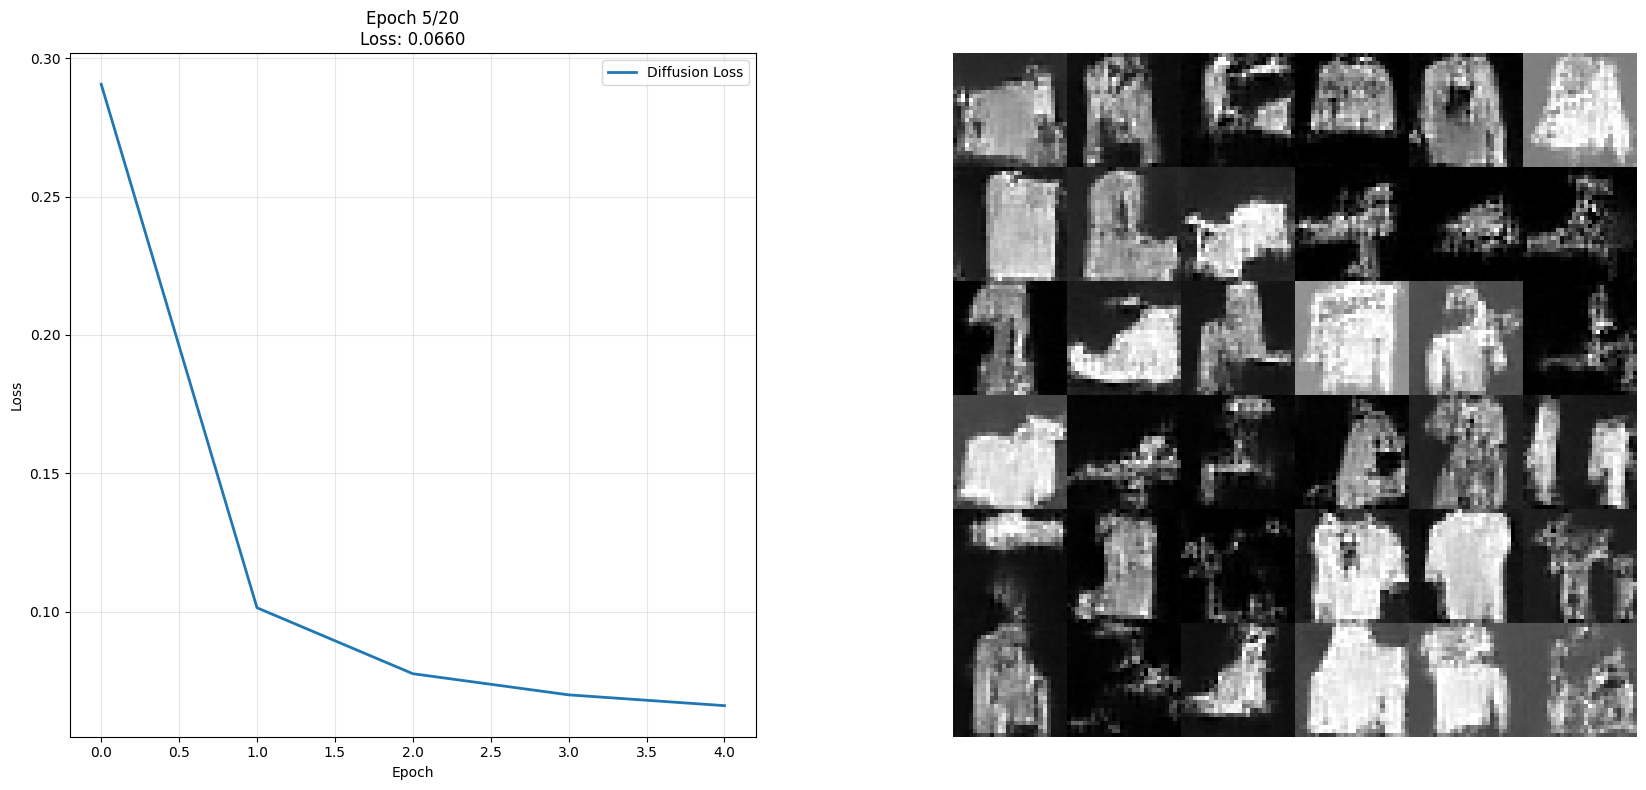

Epoch 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/20 | Avg loss: 0.0638


Epoch 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/20 | Avg loss: 0.0595


Epoch 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/20 | Avg loss: 0.0586


Epoch 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/20 | Avg loss: 0.0583


Epoch 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/20 | Avg loss: 0.0552
Generating samples...


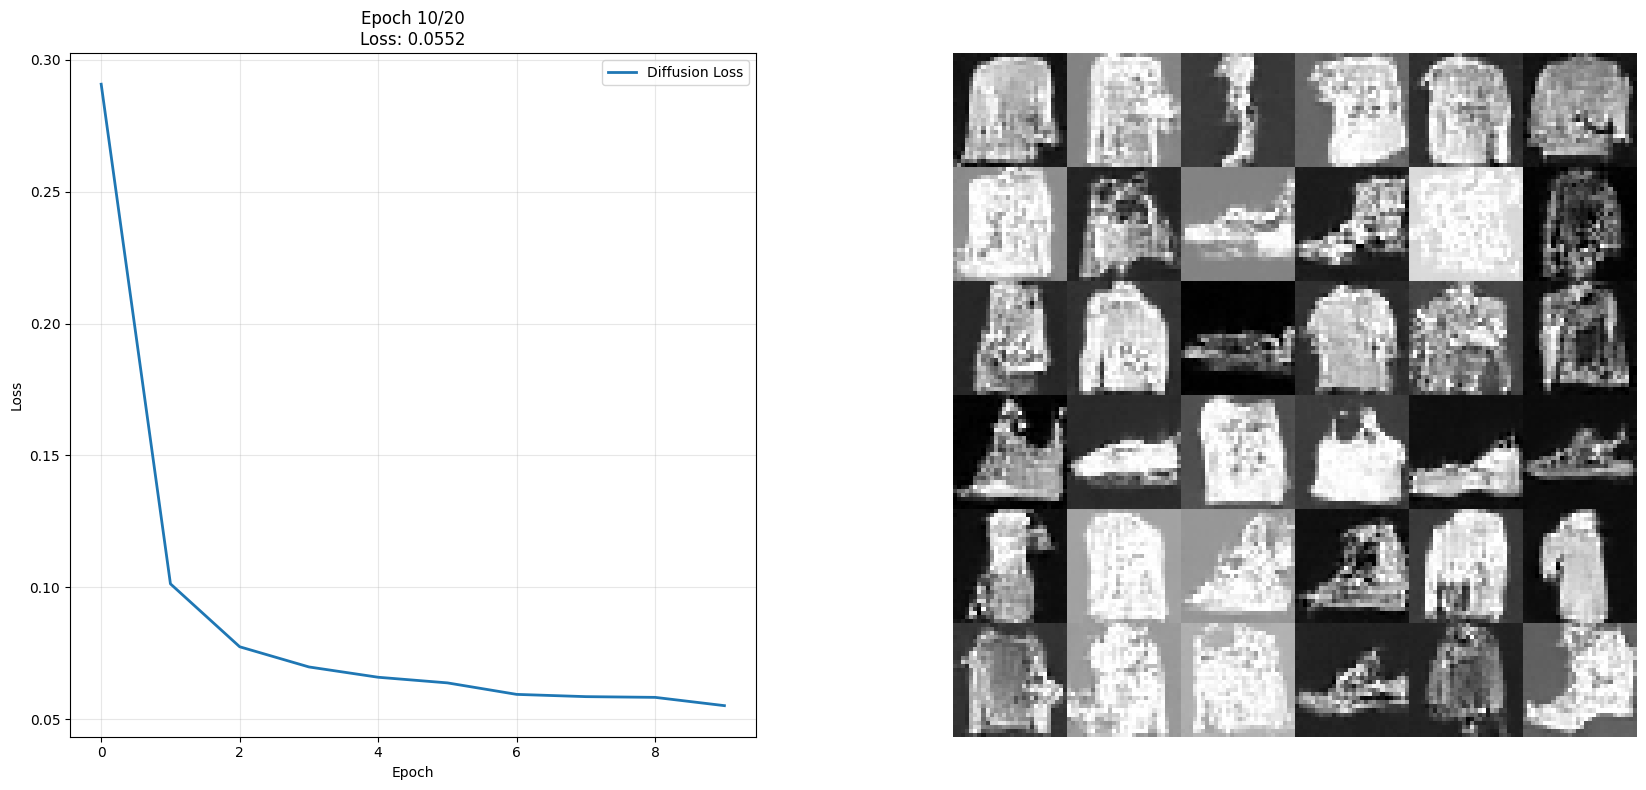

Epoch 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/20 | Avg loss: 0.0549


Epoch 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/20 | Avg loss: 0.0547


Epoch 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/20 | Avg loss: 0.0545


Epoch 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/20 | Avg loss: 0.0530


Epoch 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/20 | Avg loss: 0.0524
Generating samples...


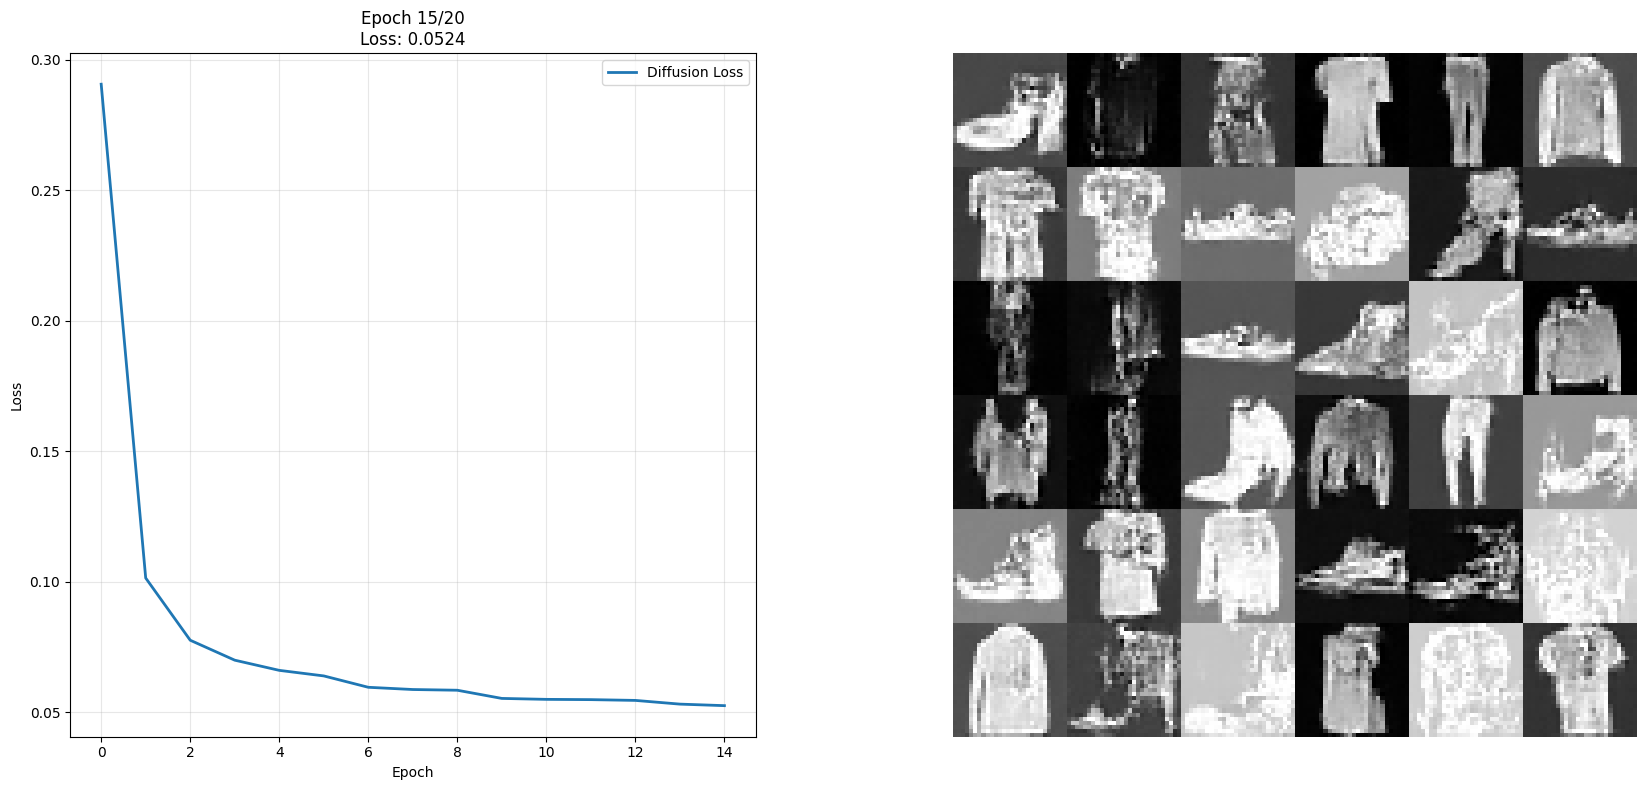

Epoch 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/20 | Avg loss: 0.0523


Epoch 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/20 | Avg loss: 0.0515


Epoch 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/20 | Avg loss: 0.0516


Epoch 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/20 | Avg loss: 0.0504


Epoch 20/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/20 | Avg loss: 0.0510
Generating samples...


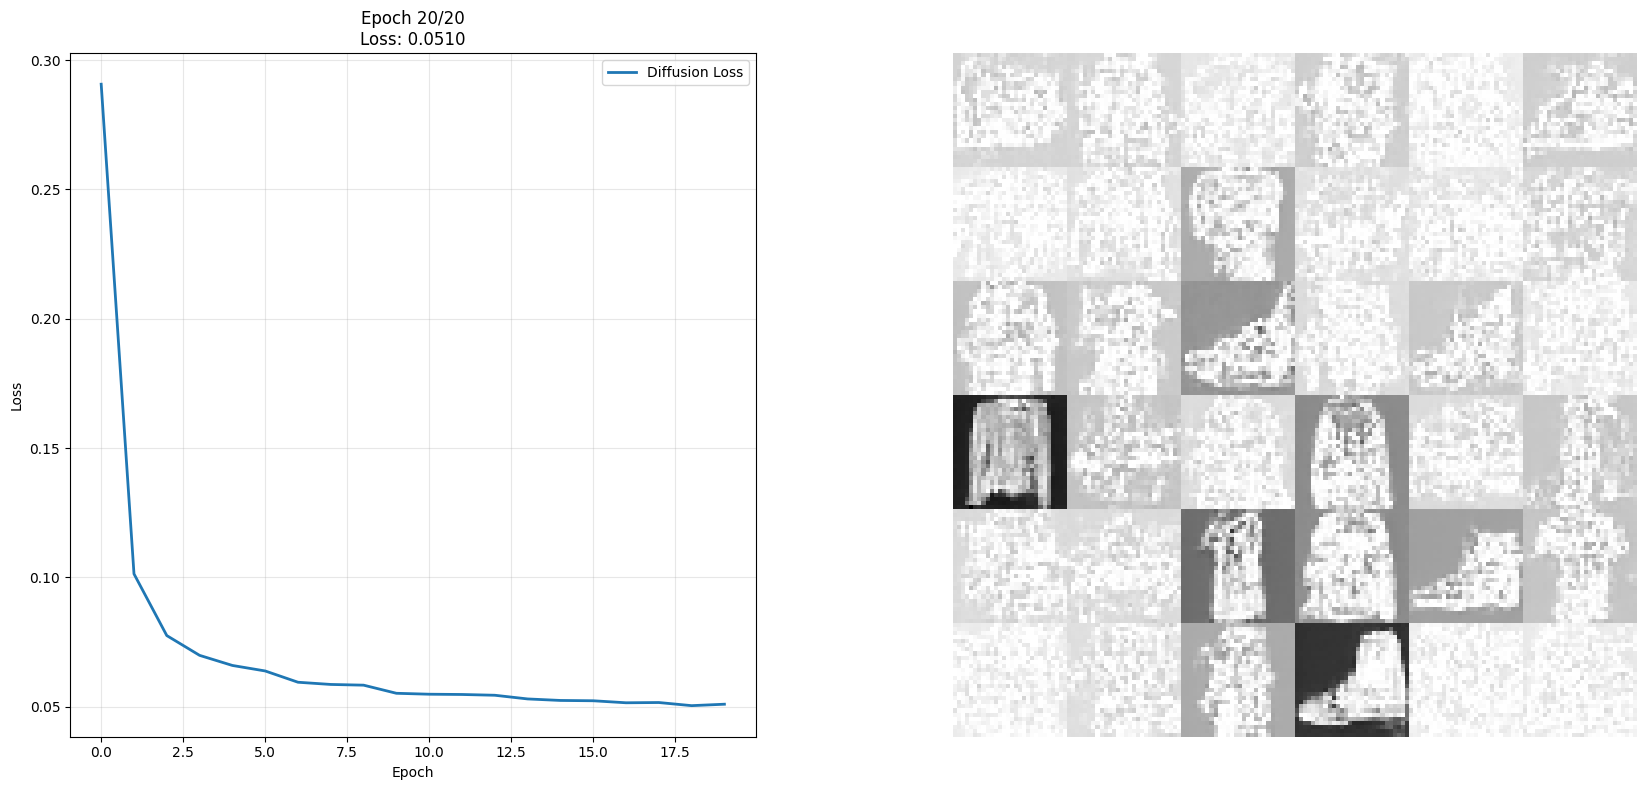

Saved final model to: ./saved_basic_ddpm/model_final.pth


In [ ]:
losses = []

for epoch in range(EPOCHS):
    basic_ddpm.model.train()
    epoch_loss = 0.0
    n = 0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for x_0, _ in progress_bar:
        x_0 = x_0.to(device)
        B = x_0.shape[0]

        t = torch.randint(0, TIMESTEPS, (B,), device=device, dtype=torch.long)

        loss = basic_ddpm.compute_loss(x_0, t)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(basic_ddpm.model.parameters(), 1.0)
        optimizer.step()

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        epoch_loss += loss.item()
        n += 1

    avg_loss = epoch_loss / max(n, 1)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f}")

    if (epoch + 1) % VIS_FREQ == 0:
        print("Generating samples...")
        with torch.no_grad():
            n_samples = 36
            samples = basic_ddpm.sample(shape=(n_samples, 1, 28, 28))
            samples = (samples * 0.5 + 0.5).clamp(0, 1)  # [-1,1] -> [0,1]

        # Plot loss + grid
        fig = plt.figure(figsize=(20, 8))
        gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

        ax_loss = fig.add_subplot(gs[0, 0])
        ax_loss.plot(losses, label="Diffusion Loss", linewidth=2)
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()
        ax_loss.grid(alpha=0.3)
        ax_loss.set_title(f"Epoch {epoch+1}/{EPOCHS}\nLoss: {avg_loss:.4f}")

        # Robust grid
        samples_cpu = samples.detach().cpu()
        B = samples_cpu.shape[0]
        grid_size = int(np.sqrt(B))
        assert grid_size * grid_size == B, "n_samples must be a perfect square (e.g., 36=6x6)"

        grid_img = np.zeros((grid_size * 28, grid_size * 28))
        for idx in range(B):
            r = idx // grid_size
            c = idx % grid_size
            img = samples_cpu[idx, 0].numpy()
            grid_img[r*28:(r+1)*28, c*28:(c+1)*28] = img

        ax_grid = fig.add_subplot(gs[0, 1])
        ax_grid.imshow(grid_img, cmap="gray")
        ax_grid.axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f"epoch_{epoch+1}.png"), dpi=150)
        plt.show()

        torch.save(
            {"epoch": epoch + 1,
             "model": basic_ddpm.model.state_dict(),
             "optimizer": optimizer.state_dict(),
             "losses": losses},
            os.path.join(SAVE_DIR, f"ckpt_{epoch+1}.pth"),
        )

torch.save(basic_ddpm.model.state_dict(), os.path.join(SAVE_DIR, "model_final.pth"))
print("Saved final model to:", os.path.join(SAVE_DIR, "model_final.pth"))


# 4. Improving DDPM Architecture components


Our baseline DDPM works: it learns recognizable Fashion-MNIST silhouettes and can sample new images from noise.  
However,  we can improve on different parts of our DDPM architecture :

## 4.1. Improving the Noise predictor

We keep the classic **encoder–decoder U-Net** shape, with **skip connections** that copy high-resolution details from the encoder to the decoder.

- **Encoder (down path):** progressively reduces spatial size  
  $
  28 \times 28 \;\rightarrow\; 14 \times 14 \;\rightarrow\; 7 \times 7
  $
  while increasing the number of channels (more abstract features).

- **Bottleneck (lowest resolution):** we add an **attention block** at $7\times 7$.  
  At this resolution attention is cheap, and it helps the model coordinate *global structure* (e.g., the overall outline of a shoe or a shirt).

- **Decoder (up path):** progressively upsamples back to full resolution  
  $
  7 \times 7 \;\rightarrow\; 14 \times 14 \;\rightarrow\; 28 \times 28
  $
  while using skip connections to recover sharp spatial details.

---

### Output head: predicting noise *and* variance

Instead of predicting only the noise, the network outputs **two channels**:
$
[\;\epsilon_\theta(x_t,t,y),\;\log\sigma_\theta^2(x_t,t,y)\;]
$

- $\epsilon_\theta$ is the usual noise prediction used for denoising.
- $\log\sigma_\theta^2$ is used to parameterize the variance of the reverse step (learned variance).

---

### Residual block with time + class conditioning

Each residual block processes a feature map \(x\) and injects conditioning information:

$$h = \mathrm{Conv}_2\Big(\mathrm{SiLU}\big(\mathrm{GN}(\mathrm{Conv}_1(\mathrm{SiLU}(\mathrm{GN}(x)))) + t_{\text{emb}} + c_{\text{emb}}\big)\Big)$$

$$\mathrm{out} = h + \mathrm{Skip}(x)$$

Where:
- $\mathrm{GN}$ is **GroupNorm** (e.g., 8 groups),
- $t_{\text{emb}}$ is the timestep embedding projected to the block channel dimension,
- $c_{\text{emb}}$ is the class embedding (for conditional generation),

---

### Attention block

At a given resolution, attention lets each spatial position interact with every other position:

$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{C}}\right)V
$$
with
$$
Q=W_q h,\quad K=W_k h,\quad V=W_v h
$$
and the output uses a residual connection:
$$
\mathrm{out} = x + W_{\text{proj}}(\mathrm{Attention}(Q,K,V))
$$



In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, num_classes, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.class_emb = nn.Embedding(num_classes, out_ch)
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, y):
        h = self.act(self.norm1(x))
        h = self.conv1(h)

        # Add time and class conditioning
        t_emb = self.time_mlp(t_emb)[:, :, None, None]
        c_emb = self.class_emb(y)[:, :, None, None]
        h = h + t_emb + c_emb

        h = self.act(self.norm2(h))
        h = self.dropout(h)
        h = self.conv2(h)

        return h + self.skip(x)


In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, H*W).transpose(1, 2)
        k = self.k(h).view(B, C, H*W)
        v = self.v(h).view(B, C, H*W).transpose(1, 2)

        attn = torch.softmax(q @ k / np.sqrt(C), dim=-1)
        h = (attn @ v).transpose(1, 2).view(B, C, H, W)
        return x + self.proj(h)


In [ ]:
class ImprovedUNet(nn.Module):
    def __init__(self, num_classes=10, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)

        # Initial conv (28x28)
        self.conv_in = nn.Conv2d(1, base_ch, 3, 1, 1)

        # Encoder
        self.down1 = nn.ModuleList([
            ResBlock(base_ch, base_ch, time_emb_dim, num_classes),
            ResBlock(base_ch, base_ch, time_emb_dim, num_classes),
        ])
        self.down1_pool = nn.Conv2d(base_ch, base_ch, 3, 2, 1)  # 28->14

        self.down2 = nn.ModuleList([
            ResBlock(base_ch, base_ch*2, time_emb_dim, num_classes),
            ResBlock(base_ch*2, base_ch*2, time_emb_dim, num_classes),
        ])
        self.down2_pool = nn.Conv2d(base_ch*2, base_ch*2, 3, 2, 1)  # 14->7

        # Bottleneck (7x7) with attention
        self.mid = nn.ModuleList([
            ResBlock(base_ch*2, base_ch*2, time_emb_dim, num_classes),
            AttentionBlock(base_ch*2),
            ResBlock(base_ch*2, base_ch*2, time_emb_dim, num_classes),
        ])

        # Decoder
        self.up2_upsample = nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1)  # 7->14
        self.up2 = nn.ModuleList([
            ResBlock(base_ch*4, base_ch*2, time_emb_dim, num_classes),  # concat: 128+128=256
            ResBlock(base_ch*2, base_ch*2, time_emb_dim, num_classes),
        ])

        self.up1_upsample = nn.ConvTranspose2d(base_ch*2, base_ch*2, 4, 2, 1)  # 14->28
        self.up1 = nn.ModuleList([
            ResBlock(base_ch*3, base_ch, time_emb_dim, num_classes),  # concat: 128+64=192
            ResBlock(base_ch, base_ch, time_emb_dim, num_classes),
        ])

        # Output - predict both noise and log variance
        self.out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, 2, 3, 1, 1)  # 2 channels: noise + log_var
        )

    def forward(self, x, t, y):
        t_emb = self.time_emb(t)

        # Encoder
        h = self.conv_in(x)  # [B, 64, 28, 28]

        h1 = h
        for block in self.down1:
            h1 = block(h1, t_emb, y)  # [B, 64, 28, 28]
        h = self.down1_pool(h1)  # [B, 64, 14, 14]

        h2 = h
        for block in self.down2:
            h2 = block(h2, t_emb, y)  # [B, 128, 14, 14]
        h = self.down2_pool(h2)  # [B, 128, 7, 7]

        # Bottleneck
        for block in self.mid:
            if isinstance(block, AttentionBlock):
                h = block(h)  # [B, 128, 7, 7]
            else:
                h = block(h, t_emb, y)  # [B, 128, 7, 7]

        # Decoder
        h = self.up2_upsample(h)  # [B, 128, 14, 14]
        h = torch.cat([h, h2], dim=1)  # [B, 256, 14, 14]
        for block in self.up2:
            h = block(h, t_emb, y)  # [B, 128, 14, 14]

        h = self.up1_upsample(h)  # [B, 128, 28, 28]
        h = torch.cat([h, h1], dim=1)  # [B, 192, 28, 28]
        for block in self.up1:
            h = block(h, t_emb, y)  # [B, 64, 28, 28]

        return self.out(h)  # [B, 1, 28, 28]


## 4.2. Beta scheduler

In the baseline model, we used a **linear beta schedule**, where the noise level increases linearly over time.  
A widely used alternative is the **cosine beta schedule**, which introduces noise more smoothly.


$$\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad f(t) = \cos^2\left(\frac{t/T + s}{1 + s} \cdot \frac{\pi}{2}\right)$$

$$\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$$

where $s = 0.008$ is a small offset to prevent $\beta_t$ from being too small near $t=0$.


In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


## 4.3 Improved DDPM implementation

### Hybrid Loss Function

Combines simple MSE loss with variational lower bound (VLB):

$$L_{\text{hybrid}} = L_{\text{simple}} + \lambda L_{\text{VLB}}$$

$$L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$

$$L_{\text{VLB}} = D_{KL}(q(x_{t-1}|x_t, x_0) \| p_\theta(x_{t-1}|x_t))$$

where $\lambda = 0.001$ balances the two terms.

---

### Classifier-Free Guidance

Improves sample quality by interpolating between conditional and unconditional predictions:

$$\tilde{\epsilon}_\theta(x_t, t, y) = \epsilon_\theta(x_t, t, \emptyset) + w \cdot (\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, \emptyset))$$

where $w$ is the guidance scale (typically $w = 2.0$), and $\emptyset$ represents the null class.

---

### DDIM Fast Sampling

Deterministic sampling with fewer steps using uniform striding:

$$x_{t-\Delta t} = \sqrt{\bar{\alpha}_{t-\Delta t}} \cdot \hat{x}_0 + \sqrt{1 - \bar{\alpha}_{t-\Delta t}} \cdot \epsilon_\theta(x_t, t)$$

where $\hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}$ is the predicted clean image.

Stride: $\Delta t = T / N_{\text{steps}}$, typically $N_{\text{steps}} = 20$ instead of $T = 1000$.

In [ ]:
# ==============================
# Diffusion Process
# ==============================
class ImprovedDDPM:
    def __init__(self, model, timesteps=1000, device='cuda'):
        self.model = model
        self.timesteps = timesteps
        self.device = device

        # Cosine schedule (improved)
        self.betas = cosine_beta_schedule(timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Precompute
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

    def p_mean_variance(self, xt, t, y):
        model_output = self.model(xt, t, y)
        pred_noise, pred_log_var = torch.chunk(model_output, 2, dim=1)

        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t][:, None, None, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]

        mean = sqrt_recip_alphas_t * (xt - self.betas[t][:, None, None, None] * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        # Learned variance (interpolate between fixed variance bounds)
        min_log = torch.log(self.posterior_variance[t])[:, None, None, None]
        max_log = torch.log(self.betas[t])[:, None, None, None]
        frac = (pred_log_var + 1) / 2  # map from [-1, 1] to [0, 1]
        log_var = frac * max_log + (1 - frac) * min_log
        var = torch.exp(log_var)

        return mean, var, pred_noise, pred_log_var

    def compute_loss(self, x0, t, noise):
        """Hybrid loss: simple MSE + learned variance (L_hybrid from paper)"""
        b = x0.size(0)

        # Forward process
        x_noisy = self.q_sample(x0, t, noise)

        # Get predictions
        model_output = self.model(x_noisy, t, self.y_for_loss)
        pred_noise, pred_log_var = torch.chunk(model_output, 2, dim=1)

        # Simple loss (MSE on noise prediction)
        mse_loss = F.mse_loss(pred_noise, noise)

        # VLB loss (learned variance)
        true_mean = (
            self.sqrt_alphas_cumprod[t][:, None, None, None] * x0 +
            self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None] * noise
        )
        true_log_var = torch.log(self.posterior_variance[t])[:, None, None, None]

        # KL divergence between predicted and true posterior
        kl = 0.5 * (
            -1.0 + pred_log_var - true_log_var +
            torch.exp(true_log_var - pred_log_var) +
            ((true_mean - self.sqrt_recip_alphas[t][:, None, None, None] *
              (x_noisy - self.betas[t][:, None, None, None] * pred_noise /
               self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None])) ** 2) *
            torch.exp(-pred_log_var)
        )
        vlb_loss = kl.mean()

        # Hybrid loss: L_simple + lambda * L_vlb
        # Paper uses lambda=0.001 for balance
        return mse_loss + 0.001 * vlb_loss

    @torch.no_grad()
    def sample(self, shape, y, guidance_scale=2.0):
        self.model.eval()
        x = torch.randn(shape, device=self.device)

        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((shape[0],), t, device=self.device, dtype=torch.long)

            # Classifier-free guidance
            output_cond = self.model(x, t_batch, y)
            output_uncond = self.model(x, t_batch, torch.full_like(y, 10))

            noise_pred_cond = output_cond[:, 0:1, :, :]
            noise_pred_uncond = output_uncond[:, 0:1, :, :]
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            mean = self.sqrt_recip_alphas[t] * (x - self.betas[t] * noise_pred / self.sqrt_one_minus_alphas_cumprod[t])

            if t > 0:
                noise = torch.randn_like(x)
                var = self.posterior_variance[t]
                x = mean + torch.sqrt(var) * noise
            else:
                x = mean

        self.model.train()
        return x

    @torch.no_grad()
    def fast_sample(self, shape, y, guidance_scale=2.0, steps=20):
        """Fast DDIM sampling with uniform striding"""
        self.model.eval()
        x = torch.randn(shape, device=self.device)

        # Uniform striding: sample every N-th timestep
        stride = self.timesteps // steps
        timesteps = list(range(self.timesteps - 1, -1, -stride))
        if timesteps[-1] != 0:
            timesteps.append(0)  # Always include t=0

        for i in range(len(timesteps) - 1):
            t = timesteps[i]
            t_next = timesteps[i + 1]

            t_batch = torch.full((shape[0],), t, device=self.device, dtype=torch.long)

            # Classifier-free guidance
            output_cond = self.model(x, t_batch, y)
            output_uncond = self.model(x, t_batch, torch.full_like(y, 10))

            noise_pred_cond = output_cond[:, 0:1, :, :]
            noise_pred_uncond = output_uncond[:, 0:1, :, :]
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            # DDIM deterministic update
            alpha_t = self.alphas_cumprod[t]
            alpha_t_next = self.alphas_cumprod[t_next] if t_next >= 0 else torch.tensor(1.0, device=self.device)

            # Predict x0
            pred_x0 = (x - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
            pred_x0 = torch.clamp(pred_x0, -1, 1)

            # Direction pointing to x_t
            dir_xt = torch.sqrt(1 - alpha_t_next) * noise_pred

            # Next sample
            x = torch.sqrt(alpha_t_next) * pred_x0 + dir_xt

        self.model.train()
        return x


In [ ]:
TIMESTEPS = 1000
BATCH_SIZE = 256
EPOCHS = 20
LR = 2e-4
NUM_CLASSES = 10
SAVE_DIR = "./saved_improved_ddqm"
VIS_FREQ = 5

os.makedirs(SAVE_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [ ]:
model = ImprovedUNet(num_classes=NUM_CLASSES+1).to(DEVICE)  # +1 for null class (CFG)
diffusion = ImprovedDDPM(model, timesteps=TIMESTEPS, device=DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")


Model params: 3,192,578


Epoch 20/20 | Loss: 0.0694
Generating samples...


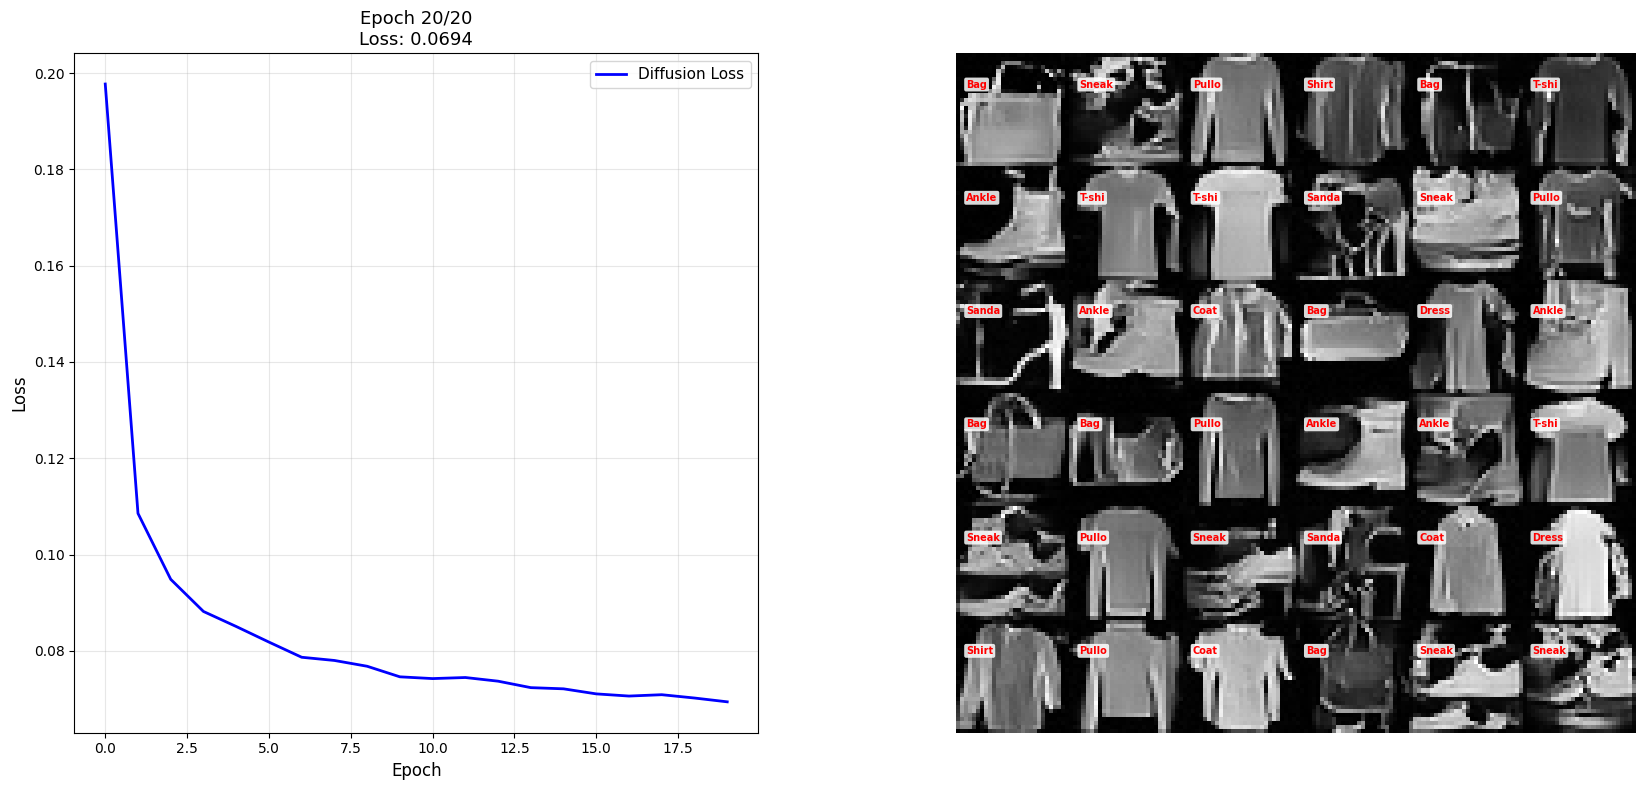

In [ ]:
# ==============================
# Training
# ==============================
losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True):
        x, y = x.to(DEVICE), y.to(DEVICE)
        b = x.size(0)

        # Classifier-free guidance: 10% dropout
        y_input = y.clone()
        mask = torch.rand(b, device=DEVICE) < 0.1
        y_input[mask] = NUM_CLASSES  # null class

        # Sample random timesteps
        t = torch.randint(0, TIMESTEPS, (b,), device=DEVICE)

        # Add noise
        noise = torch.randn_like(x)
        x_noisy = diffusion.q_sample(x, t, noise)

        # Predict noise and variance
        model_output = model(x_noisy, t, y_input)
        pred_noise, pred_log_var = torch.chunk(model_output, 2, dim=1)

        # Hybrid loss: L_simple (MSE) + lambda * L_vlb (learned variance)
        mse_loss = F.mse_loss(pred_noise, noise)

        # Simplified VLB (just regularize log_var to be reasonable)
        vlb_loss = (pred_log_var ** 2).mean()

        loss = mse_loss + 0.001 * vlb_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        n += 1

    avg_loss = epoch_loss / n
    losses.append(avg_loss)

    # Visualization
    if epoch % VIS_FREQ == 0:
        clear_output(wait=True)
        print(f"Epoch {epoch}/{EPOCHS} | Loss: {avg_loss:.4f}")
        print(f"Generating samples...")

        fig = plt.figure(figsize=(20, 8))
        gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

        # Loss curve
        ax_loss = fig.add_subplot(gs[0, 0])
        ax_loss.plot(losses, label="Diffusion Loss", color="blue", linewidth=2)
        ax_loss.set_xlabel("Epoch", fontsize=12)
        ax_loss.set_ylabel("Loss", fontsize=12)
        ax_loss.legend(fontsize=11)
        ax_loss.grid(alpha=0.3)
        ax_loss.set_title(f"Epoch {epoch}/{EPOCHS}\nLoss: {avg_loss:.4f}", fontsize=13)

        # Sample images (ULTRA FAST - only 36 samples with 20 steps)
        model.eval()
        with torch.no_grad():
            n_samples = 36  # 6x6 grid
            y_sample = torch.randint(0, NUM_CLASSES, (n_samples,), device=DEVICE)
            samples = diffusion.fast_sample((n_samples, 1, 28, 28), y_sample, guidance_scale=2.0, steps=20)
            samples = samples * 0.5 + 0.5
            samples = torch.clamp(samples, 0, 1)

            # Build 6x6 grid
            img_size = 28
            grid_img = np.ones((img_size * 6, img_size * 6))

            for idx in range(36):
                row = idx // 6
                col = idx % 6
                img = samples[idx].cpu().squeeze().numpy()
                y_start = row * img_size
                x_start = col * img_size
                grid_img[y_start:y_start+img_size, x_start:x_start+img_size] = img

            ax_grid = fig.add_subplot(gs[0, 1])
            ax_grid.imshow(grid_img, cmap="gray")
            ax_grid.axis("off")

            # Add labels
            for idx in range(36):
                row = idx // 6
                col = idx % 6
                class_idx = y_sample[idx].item()
                class_name = CLASS_NAMES[class_idx][:5]
                x_pos = col * img_size + 2
                y_pos = row * img_size + 8
                ax_grid.text(
                    x_pos, y_pos, class_name,
                    color="red", fontsize=7, fontweight="bold",
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.85, edgecolor="none")
                )

        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f"epoch_{epoch}.png"), dpi=150)
        plt.show()

        # Save checkpoint
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "losses": losses,
        }, os.path.join(SAVE_DIR, f"ckpt_{epoch}.pth"))
    else:
        # Print progress for non-visualization epochs
        print(f"Epoch {epoch}/{EPOCHS} | Loss: {avg_loss:.4f}")

# ==============================
# Save final
# ==============================
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "model_final.pth"))
